In [18]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:

inspector = inspect(engine)

columns1 = inspector.get_columns('measurement')
for c in columns1:
    print(c['name'])

print("-"*10)
    
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'])

id
station
date
prcp
tobs
----------
id
station
name
latitude
longitude
elevation


In [27]:
# Find the most recent date in the data set.
most_recentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recentdate)

('2017-08-23',)


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-18'),
  Text(0.0, 0, '2016-08-24'),
  Text(500.0, 0, '2016-11-17'),
  Text(1000.0, 0, '2017-02-14'),
  Text(1500.0, 0, '2017-05-15'),
  Text(2000.0, 0, '2017-08-19'),
  Text(2500.0, 0, '')])

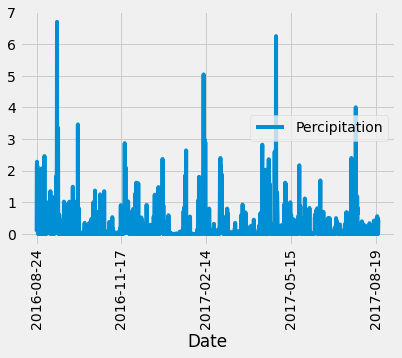

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_yearago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').filter(Measurement.prcp != 'None').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_df = pd.DataFrame(year_prcp, columns=['Date', 'Percipitation'])

# Sort the dataframe by date
year_df = year_df.set_index(year_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
x = year_df['Date']
y= year_df['Percipitation']
year_df.plot()
plt.xticks(rotation= 90)


In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_df.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [31]:
session.query(Measurement.station).distinct().count()

9

In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_ls = []
station_count = []

for stations in session.query(Measurement.station).distinct():
    station_ls.append(stations[0])
    station_count.append(session.query(Measurement).filter(Measurement.station == stations[0]).count())

In [33]:
station_frq = pd.DataFrame({'Station Name': station_ls,
                           'Frequency': station_count})
station_frq.sort_values(by=['Frequency'], ascending=False)


,Station Name,Frequency
6,USC00519281,2772
0,USC00519397,2724
1,USC00513117,2709
5,USC00519523,2669
8,USC00516128,2612
2,USC00514830,2202
7,USC00511918,1979
3,USC00517948,1372
4,USC00518838,511


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.avg(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
      ]
most_pop_info = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
most_pop_info

[(71.66378066378067, 54.0, 85.0)]

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_tobs = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.date > '2016-08-23').filter(
    Measurement.tobs != 'None').filter(
    Measurement.station == 'USC00519281').order_by(
    Measurement.date).all()

last_year_tobs

tobs_df = pd.DataFrame(last_year_tobs, columns= ['Date', 'Temperature'])


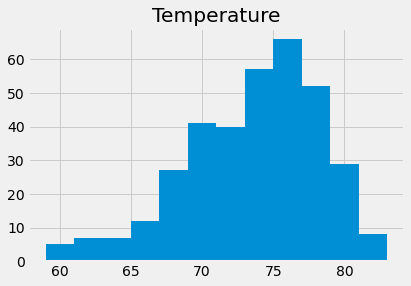

In [36]:
hist = tobs_df.hist(bins=12)


# Close session

In [37]:
#Flask Action
from flask import Flask, jsonify

app = Flask(__name__)

@app.route("/")
def home():
    print("Server received request for 'Home' page...")
    return( f"Welcome to the homepage"
           f"Routes Available are:"
           f"/api/v1.0/precipitation"
           f"/api/v1.0/stations"
           f"/api/v1.0/tobs"
           f"/api/v1.0/<start>"
           f"/api/v1.0/<start>/<end>"
          )

@app.route("/api/v1.0/precipitation")
def about():
    print("Server received request for 'precipitation' page...")
    
    all_dates = session.query(Measurement.date).all()
    all_prcp = session.query(Measurement.prcp).all()

    prcp_dic = {all_dates[i]: all_prcp[i] for i in range(len(all_dates))}
    
    return jsonify(prcp_dic)



if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 48] Address already in use

In [45]:
# Close Session
session.close()